# Analyse verdeling PDs binnen een cluster
De lopende hypothese is dat PDs binnen een cluster normaal verdeeld zijn. Hierbij een poging om van de verschillende datasets binnen de gevonden clusters de parameters ($\mu$ en $\sigma$) voor een normale verdeling af te leiden.
Hierbij is het gemiddelde $\mu$ de meest waarschijnlijke plek waar de fout in de kabel zit, en de standaarddeviatie $\sigma$ hangt waarschijnlijk af van de nauwkeurigheid van de meting.
$\mu$ is voor de dataanalyse dus niet zo interessant, maar voor de monteurs in het veld wel. Bij $\sigma$ is dat omgekeerd: Als die tussen de verschillende clusters niet veel varieert, kunnen we daaruit conclusies trekken.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import ipywidgets
from IPython.display import display, clear_output, Javascript, Markdown

import poisson_clustering as ps

In [2]:
circuits, cable_config, partial_discharges, warning = ps.load_data()
circ = circuits[0]
# Lengte van de kabel is gegeven in de cable config
cable_length = cable_config[circ]['Cumulative length (m)'].values[-1]
pardis = partial_discharges[circ]

In [3]:
boolean_series, locations, charges, times, bins = ps.identify_suspicious_areas(pardis, cable_length)

In [4]:
clusters = ps.cluster_boolean_series(boolean_series)
print(clusters)

{(232, 242), (216, 226)}


/home/rick/Documents/Universiteit/Wiskunde/Modellenpracticum/venv/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


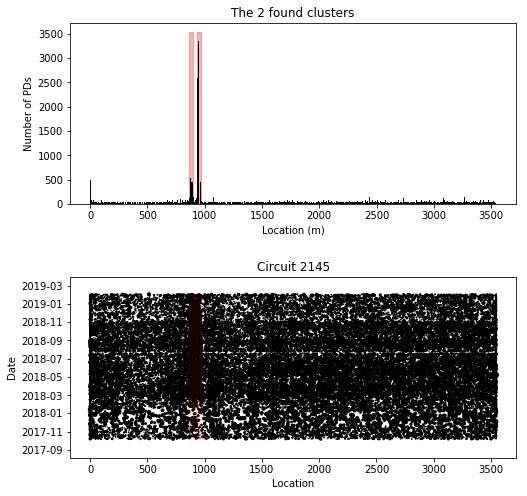

In [5]:
ps.show_plot(locations, times, charges, bins, clusters, circ)

In [31]:
clusters_meters = [tuple(a*4.0 for a in x) for x in clusters]
clusters_meters

[(928.0, 968.0), (864.0, 904.0)]

In [38]:
def normal_parameters(locations, clusters):
    result = []
    for current_cluster in clusters:
        min_location, max_location = current_cluster[0], current_cluster[1]
        cluster_bools = [min_location <= loc <= max_location for loc in locations] 
        cluster_pds = locations[cluster_bools]
        mu = np.mean(cluster_pds)
        sigma = np.std(cluster_pds)
        result.append((mu, sigma))
    return result

In [39]:
normal_parameters(locations, clusters_meters)

[(944.8126273169269, 7.873172965310522),
 (885.8054537595333, 9.713855577922422)]

In [41]:
def calculate_all_normal_parameters():
    circuits, cable_config, partial_discharges, warning = ps.load_data()
    result = []
    for circ in circuits:
        # Lengte van de kabel is gegeven in de cable config
        cable_length = cable_config[circ]['Cumulative length (m)'].values[-1]
        pardis = partial_discharges[circ]
        boolean_series, locations, charges, times, bins = ps.identify_suspicious_areas(pardis, cable_length)
        clusters = ps.cluster_boolean_series(boolean_series)
        clusters_meters = [tuple(a*4.0 for a in x) for x in clusters]
        result.extend(normal_parameters(locations, clusters_meters))
    return result

In [45]:
parameters = calculate_all_normal_parameters()

In [58]:
mus = [x[0] for x in parameters]
sigmas = [x[1] for x in parameters]
sigmas = np.sort(sigmas)

# Resultaten

| Index | Standaarddeviatie $\sigma$ |
|-------|--------------------|
| 0     | 1.6550244993312642 |
| 1     | 3.2315252213453234 |
| 2     | 3.450029384328724  |
| 3     | 3.542063847856088  |
| 4     | 3.844411015211924  |
| 5     | 4.0750709785626915 |
| 6     | 5.090581865328526  |
| 7     | 5.105355267443109  |
| 8     | 5.1727821718132905 |
| 9     | 5.291165597102782  |
| 10    | 5.47134252876542   |
| 11    | 5.550966954094647  |
| 12    | 5.787196445265007  |
| 13    | 7.431155652770754  |
| 14    | 7.717696711293299  |
| 15    | 7.873172965310522  |
| 16    | 8.370085399924362  |
| 17    | 8.963991042203217  |
| 18    | 9.713855577922422  |
| 19    | 11.662159186970019 |

**Gemiddelde $\sigma$**: 5.9499816156421685

**Standaarddeviatie**: 2.4443024332909373

Een beetje een kleine sample size als je het mij vraagt. Het gros van de standaarddeviates zit tussen de 5 en 8, wat ook te zien is aan het gemiddelde van ongeveer 6 en de bovengenoemde standaarddeviatie. Er zijn echter wel een aantal uitschieters die je niet zou verwachten als de standaarddeviaties allemaal ongeveer hetzelfde zouden zijn.

Ik heb nog niet gekeken naar welke clusters horen bij de verschillende $\sigma$.